In [2484]:
# Alex Walczak | CS 189 | Homework 6: Neural Networks

# Import functions and libraries
from __future__ import division, print_function
import cPickle as pickle
import numpy as np, matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy.io
from pylab import rcParams
from sklearn.cross_validation import KFold
rcParams['figure.figsize'] = 7, 7
import csv
%matplotlib inline
from scipy import ndimage

In [2996]:
# # # Serialize object
# f = open('pick_name.pickle', 'wb')
# pickle.dump(NN, f, protocol=pickle.HIGHEST_PROTOCOL)
# f.close()

In [2997]:
# # Load object
# f = open('pick_name.pickle', 'rb')
# _NN = pickle.load(f)
# f.close()

In [2999]:
# rand_inds = np.random.permutation(60000)

In [3000]:
# Load & Preprocess (training and validation sets)
# To enable bias, I append a 1 to front of each feature. x0 = 1. Then later, w0 = TBD.
data = scipy.io.loadmat("dataset/train.mat")
imgs = np.reshape( data["train_images"], (-1, 60000)).T[rand_inds]
labels0 = data["train_labels"][rand_inds]

####### gooooooood ######## ######## ######## ########
imgs = imgs/255
imgs_mean = np.mean(imgs, axis = 0)
imgs = imgs - imgs_mean # zero-center the data (important)
######## ######## ######## ######## ######## ########            

# 0.1/.9 target reachable by logistic and tanh functions.
# cs.cmu.edu/afs/cs/academic/class/15883-f15/slides/backprop.pdf
# Compare to: normal (unreachable) 0/1 targets.

all_labels = []
for label in labels0:
    l = np.zeros(10) + 0.02
    l[label] = 0.98
    all_labels += [l]
all_labels = np.array(all_labels)

images_with_concated1 = np.c_[ np.ones(len(imgs)) , imgs ]

images = images_with_concated1[10000:]
labels = all_labels[10000:]

# Create validation set, size 10,000.
vimages = images_with_concated1[:10000]
vlabels = all_labels[:10000]

# Uncomment and run for sanity check on preprocessing.
# I = 35;
# plt.figure(); showme(images[I]); print('First image (train):',labels[I].argmax())
# plt.figure(); showme(vimages[I]); print('Second image (validation):', vlabels[I].argmax())

In [3001]:
# Load & Preprocess (test set)
test_images = scipy.io.loadmat("dataset/test.mat")['test_images']
test_imgs = []
# Load and norm test images.
for i in range(len(test_images)):
    ti = test_images[i]
    ti = np.ndarray.flatten(np.fliplr(((np.rot90(np.reshape(ti, (28,-1)))).T)))
    # ^ Reshape data
    test_imgs += [ti]
    
test_imgs = np.array(test_imgs)

# test_imgs = np.reshape( test_images, (-1, 10000)).T
test_imgs_scaled = test_imgs/255
test_imgs = test_imgs_scaled - imgs_mean
test_imgs = np.c_[ np.ones(len(test_imgs)) , test_imgs ]

In [3004]:
# Computation

def sigmoid(gamma):
    # activiation function for output units
    return 1/(1+np.exp(-gamma))

def deriv_sigmoid(gamma):
    # d/d(gamma) sigmoid
    return sigmoid(gamma)*(1-sigmoid(gamma))

def tanh(gamma):
    # activiation function for hidden units
    return np.tanh(gamma)

def deriv_tanh(gamma):
    # d/d(gamma) tanh
    return -tanh(gamma)**2 + 1

def square_error(x,y,W,V):
    return -1*-1*0.5*np.sum((y - sigmoid(V.dot(tanh(W.dot(x)))))**2)

def cross_entropy(x,y,W,V):
    return -1*-1*-np.sum(y*np.log(sigmoid(V.dot(tanh(W.dot(x))))) + (1-y)*np.log(1-sigmoid(V.dot(tanh(W.dot(x))))))

def evaluate_grad(gW,gV,W,V):
    wnum, wden = np.linalg.norm(gW-W), np.linalg.norm(gW+W)
    vnum, vden = np.linalg.norm(gV-V), np.linalg.norm(gV+V)
    if vnum == vden == 0:
        vden = 1
    if wnum == wden == 0:
        wden = 1
    return wnum/wden, vnum/vden

# Utilities

def showme(img):
    # skip first entry of array because it's always a one.
    plt.figure()
    plt.imshow(np.reshape(img[1:],(28,-1)))
    
def save_labels(labels, fname):
    # Ex. save_labels(spam_labels,'kaggle_spam_mean.csv')
    f1 = open(fname, 'w+')
    print('Id,Category', file = f1)
    for i in range(len(labels)):
        print(str(i+1)+","+str(int(labels[i])), file = f1)

In [3015]:
class Neural_Network():
    # (785-200-10)
    # with a single hidden layer.
    # classifies MNIST images.
    
    def __init__(self, learn_weights, cost_fn=None, Lambda=0.1, momentum=0.5, MAX_ITERS=10e6):
        self.ID = str(np.random.randint(10e4,10e8))
        self.cost_fn = cost_fn
        self.Lambda = Lambda
        self.momentumW = momentum
        self.momentumV = momentum
        self.stddW = 1/np.sqrt(785)
        self.stddV = 1/np.sqrt(200)
        self.W = self.stddW*np.random.randn(200, 785)
        self.V = self.stddV*np.random.randn(10, 200)

        self.prev_gradV = 0
        self.prev_gradW = 0
        
#       Different layers learn at different rates.
#       This was also mentioned in the same CMU ppt as in the early slides.
#       Input-to-hidden (i2h) weights learn more slowly than hidden-to-output (h2o) weights.

        # learn_weights = (i2h_lr, i2h_inc, i2h_dec, h2o_lr, h2o_inc, h2o_dec)
        # 7.75% error for (0.1, 1.02, 0.6, 0.02, 1.002, 0.4)
        
        self.i2h_lr = learn_weights[0] 
        self.i2h_inc = learn_weights[1]
        self.i2h_dec = learn_weights[2]
        self.h2o_lr = learn_weights[3]
        self.h2o_inc = learn_weights[4]
        self.h2o_dec = learn_weights[5]
    
        self.iters = 1
        self.total_iters = 1
        self.MAX_ITERS = MAX_ITERS
    
        self.W_dot_x = 'Nothing yet!'
        self.tanh_W_dot_x = 'Nothing yet!'
        self.forward = 'Nothing yet!'
        
        self.last_error = 10e90
        self.oldW = None
        self.oldV = None
        self.alternateVW = 1
        
        self.errors = np.array([10,20,30])
        
    def train(self, images, labels, learn_weights, epoch, error_inc=1.0001, error_func=None, iters=None, reset_iters=False, vimages=None, vlabels=None):

        self.epoch = epoch #4*10e3
        self.error_inc = error_inc # if the error increased by more than this percentage of last epoch, then we did worse. Change back weights.
        
        self.i2h_lr = learn_weights[0] 
        self.i2h_inc = learn_weights[1]
        self.i2h_dec = learn_weights[2]
        self.h2o_lr = learn_weights[3]
        self.h2o_inc = learn_weights[4]
        self.h2o_dec = learn_weights[5]
        
        self.iters = 1
        
        if reset_iters:
            self.total_iters = 1
        
        if error_func == None:
            print('Please choose an error function.')
            return
        if error_func == 'square_error':
            gradVfunc = self.gradV_square_error
            gradWfunc = self.gradW_square_error
            _error = square_error
        if error_func == 'cross_entropy':
            gradVfunc = self.gradV_cross_entropy_error
            gradWfunc = self.gradW_cross_entropy_error
            _error = cross_entropy

        if iters == None:
            iters = self.MAX_ITERS
            
        while self.iters <= iters:
            idx = np.random.randint(1,len(images))
            x = images[idx]
            
            self.W_dot_x = self.W.dot(x)
            self.tanh_W_dot_x = tanh(self.W_dot_x)
            self.forward = sigmoid(self.V.dot(self.tanh_W_dot_x))

            _gradV = self.h2o_lr*gradVfunc(x, labels[idx])
            _gradW = self.i2h_lr*gradWfunc(x, labels[idx])
            
            self.V += (_gradV + self.momentumV*self.prev_gradV) # does sign/order matter?
            self.W += (_gradW + self.momentumW*self.prev_gradW) #       ''

            self.prev_gradV = _gradV
            self.prev_gradW = _gradW

            self.iters += 1
            self.total_iters += 1
    
            # Adjust learning rate.
        
            if (self.total_iters % self.epoch) == 0:
                
                self.i2h_inc = self.i2h_inc*(1 - (self.total_iters/self.MAX_ITERS))
                self.i2h_dec = self.i2h_dec*(1 - (self.total_iters/self.MAX_ITERS))
                self.h2o_inc = self.h2o_inc*(1 - (self.total_iters/self.MAX_ITERS))
                self.h2o_dec = self.h2o_dec*(1 - (self.total_iters/self.MAX_ITERS))
                
                data_error, XXX = self.check_error(vimages, vlabels)
                
                if error_func == 'cross_entropy':
                    error = self.cost_xe(vimages, vlabels)
                if error_func == 'square_error':
                    error = self.cost_se(vimages, vlabels)
                
                self.errors = np.append(self.errors,error)
                    
                self.alternateVW += 1
                
                if error < self.last_error:
                    
                    if (error == self.errors[3:].min()):
                        # Pickle if best.
                        # # # Serialize object
                        f = open('BEST_ECOUNTERED_'+self.ID+'_.pickle', 'wb')
                        pickle.dump(self, f, protocol=pickle.HIGHEST_PROTOCOL)
                        f.close()
                        print('pickled!')
                    
                    print('better!')
                    
                    if (error < 1.0):
                        print('good enough!')
                        break
                    
                    # Doing well? Speed up!
                    if self.alternateVW % 2 == 0:
                        self.i2h_lr = self.i2h_lr*self.i2h_inc
                        self.oldW = np.copy(self.W)
                        self.momentumW = self.momentumW*1.1
                        
                    else:
                        self.h2o_lr = self.h2o_lr*self.h2o_inc
                        self.oldV = np.copy(self.V)
                        self.momentumV = self.momentumV*1.05
                        
                if error >= self.last_error*self.error_inc:
                    
                    print('worse')
                                        
                    # Getting worse? Slow down!
                    if self.alternateVW % 2 == 1: # (sometimes) trying 1 not 0 because if I just change W, that was a bad change bc error increased.
                                                  # experiment with this!
                        self.i2h_lr = self.i2h_dec*self.i2h_lr # i2h_dec should be at least bigger than h2o_dec because don't want i2h_lr to slow down too much (takes longer to get up)
                        self.W = np.copy(self.oldW)
                        self.momentumW = self.momentumW*0.6
                        
                    else:
                        self.h2o_lr = self.h2o_dec*self.h2o_lr
                        self.V = np.copy(self.oldV)
                        self.momentumV = self.momentumV*0.3
                        
                self.last_error = error
                
                # If std dev of most recent errors is low, assume we are stuck in a local minimum.
                if np.std(self.errors[-3:]) < 0.10:
                    print('Errors not changing! Time to shake things up.')
                    self.momentumW = np.random.randint(5,20)/150
                    self.momentumV = np.random.randint(5,100)/1000
                    self.i2h_lr += 0.0001*np.random.randint(1,61)
                    self.h2o_lr += 0.0001**np.random.randint(1,61)
                    self.errors[-1]+=10e9
                
                if self.i2h_lr < 10e-8:
                    print('i2h too small!')
                    self.i2h_lr += 10e-6
                    
                if self.h2o_lr < 10e-14:
                    print('h2o too small!')
                    self.h2o_lr += 10e-10
                    
                print(self.i2h_lr, self.h2o_lr, self.momentumW, self.momentumV)
                
    def cost_xe(self, vimages, vlabels):
        tot=0
        for i in range(len(vimages)):
            tot+=-np.sum(vlabels[i]*np.log(sigmoid(self.V.dot(tanh(self.W.dot(vimages[i]))))) + (1-vlabels[i])*np.log(1-sigmoid(self.V.dot(tanh(self.W.dot(vimages[i]))))))
        print('XE Cost', tot)
        return tot
    
    def cost_se(self, vimages, vlabels):
        tot=0
        for i in range(len(vimages)):
            tot+=np.sum( (vlabels[i] - sigmoid(self.V.dot(tanh(self.W.dot(vimages[i])))))**2 )
        print('SE Cost', tot)
        return tot
            
    def predict(self, image):
        return sigmoid(self.V.dot(tanh(self.W.dot(image))))

    def predict_all(self, images):
        return(np.array(map(self.predict, images)))
    
    def check_error(self, images, labels):
        # labels are assumed to be each of size 10 as in preprocessing.
        pdn = self.predict_all(images)
        pdn_labels = np.array([p.argmax() for p in pdn])
        labels = np.array([l.argmax() for l in labels])
        error = 100*np.sum(pdn_labels != labels)/len(labels)
        print('Error', error,'%')
        return error, pdn_labels
    
    def check_grad(self, error_func, x, y, eps=10e-5):
        # Call check grad to set self.forward before comparing to grad_XXX_error
        self.forward = sigmoid(self.V.dot(tanh(self.W.dot(x))))
        
        ogW, ogV = np.copy(self.W), np.copy(self.V)
        gradW, gradV = np.zeros(self.W.shape),np.copy( np.zeros(self.V.shape))
        
        for j in range(len(self.W)):
            for i in range(len(self.W[j])):
                og = self.W[j][i]
                self.W[j][i] = og + eps
                res1 = error_func(x,y,self.W,self.V)
                self.W[j][i] = og - eps
                res2 = error_func(x,y,self.W,self.V)
                gradW[j][i] = (res1 - res2)/(2*eps)
                self.W[j][i] = og
        
        for j in range(len(self.V)):
            for i in range(len(self.V[j])):
                og = self.V[j][i]
                self.V[j][i] = og + eps
                res1 = error_func(x,y,self.W,self.V)
                self.V[j][i] = og - eps
                res2 = error_func(x,y,self.W,self.V)
                gradV[j][i] = (res1 - res2)/(2*eps)
                self.V[j][i] = og

        self.W, self.V = ogW, ogV
        return gradW, gradV
    
    def gradW_square_error(self, x,y):
        a = (((y - self.forward)*deriv_sigmoid(self.V.dot(self.tanh_W_dot_x))))
        return np.outer(self.V.T.dot(a)*deriv_tanh(self.W_dot_x), x.T)

    def gradV_square_error(self, x,y):
        return np.outer((y - self.forward)*deriv_sigmoid(self.V.dot(self.tanh_W_dot_x)), self.tanh_W_dot_x.T)

    def gradV_cross_entropy_error(self, x,y):
        return np.outer((y - self.forward), self.tanh_W_dot_x.T)

    def gradW_cross_entropy_error(self,x,y):
        return np.outer(((self.V.T.dot(y - self.forward))*deriv_tanh(self.W_dot_x)), x.T)

    def grad_cross_entropy(self, x,y):
        return self.gradW_cross_entropy_error(x,y), self.gradV_cross_entropy_error(x,y)
    
    def grad_square_error(self, x,y):
        return self.gradW_square_error(x,y), self.gradV_square_error(x,y)

In [3038]:
# Training and testing

In [ ]:
# Values I had good results using.
_i2h_lr =  0.1
_i2h_inc = 1.015
_i2h_dec = 0.8
_h2o_lr = 0.001
_h2o_inc = 1.0001
_h2o_dec = 0.45
_epoch = 3*10e3
_error_inc = 1+10e-6
_momentum = 0.001

learning_rate_weights = (_i2h_lr, _i2h_inc, _i2h_dec, _h2o_lr, _h2o_inc, _h2o_dec)

In [3020]:
# Training with XE Loss

NN = Neural_Network(learn_weights=learning_rate_weights, momentum=_momentum)

for i in range(10):
    print(i)
    NN.train(images, labels, epoch=_epoch, error_inc=_error_inc, learn_weights=learning_rate_weights, error_func='cross_entropy', iters=10e4, reset_iters=False, vimages=vimages, vlabels=vlabels)
    print()

# This gets printed: (error, self.i2h_lr, self.h2o_lr, self.momentumW, self.momentumV)

In [3036]:
# Training with SE Loss

# Run this line if not creating new instance of NN
# learning_rate_weights = (NN.i2h_lr, _i2h_inc, _i2h_dec, NN.h2o_lr, _h2o_inc, _h2o_dec)

NN = Neural_Network(learn_weights=learning_rate_weights, momentum=_momentum)

for i in range(10):
    print(i)
    NN.train(images, labels, epoch=_epoch, error_inc=_error_inc, learn_weights=learning_rate_weights, error_func='square_error', iters=10e4, reset_iters=False, vimages=vimages, vlabels=vlabels)
    print()


7


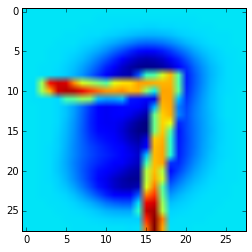

In [3037]:
ti = vimages[900]
pdn = NN.predict(ti)
print(pdn.argmax())
showme(ti)

In [ ]:
# Generate test data labels.

In [2974]:
# __, predicted_labels = best_NN.check_error(test_imgs, vlabels)

# # Sanity check.
# _t = np.array([test_imgs[1], test_imgs[22], test_imgs[333], test_imgs[4444]])
# _l = np.array([predicted_labels[1], predicted_labels[22], predicted_labels[333], predicted_labels[4444]])
# for i in range(len(_t)):
#     showme(_t[i])
#     print('Label:', _l[i])

# Save labels.
# save_labels(predicted_labels, '784_200_10_NN_simple_preproc_labels.csv')

# Kaggle Score: 0.97640
# NN ID: 354600521

In [ ]:
# Below, data saved for reference
#
# iterations: 10e3 to 20*10e4 with 67 pts.
# loss = array([ 13432.93569313,  12606.51591719,  12301.06718922,  12110.30162897,
#         12042.57279805,  11949.50139832,  11940.63769764,  11846.70304254,
#         11799.9777952 ,  11774.20877548,  11773.6444034 ,  11767.0068726 ,
#         11764.23110766,  11724.4665161 ,  11729.1478896 ,  11706.98543717,
#         11693.03176399,  11693.04117115,  11699.62146882,  11690.84224179,
#         11703.65743183,  11697.59636369,  11699.06362548,  11671.76060895,
#         11698.92654993,  11666.41520784,  11673.01219267,  11711.40579961,
#         11688.67719221,  11649.71231889,  11732.35222877,  11700.34949357,
#         11697.32432718,  11688.9760188 ,  11705.92981412,  11670.40111919,
#         11670.51814198,  11685.40041635,  11657.34283291,  11641.43742866,
#         11686.59015803,  11666.59176936,  11674.29694423,  11675.79256358,
#         11641.35108495,  11648.90007011,  11682.20514718,  11692.19700681,
#         11642.26152735,  11630.38092284,  11669.01027341,  11686.12114843,
#         11648.40395379,  11692.13425494,  11652.37114204,  11629.60390472,
#         11665.57532849,  11674.92947925,  11643.88537853,  11626.71857277,
#         11680.50829383,  11662.69287411,  11663.85694344,  11693.98101753,
#         11653.85801366,  11633.78618821])
# accuracy = np.array([5.86 , 4.22 , 3.76 , 3.27 , 3.2 , 2.98 , 3.03 , 2.68 , 2.69 , 2.54 , 2.44 , 2.57 , 2.68 , 2.43 , 2.4 , 2.4 , 2.32 , 2.4 , 2.54 , 2.43 , 2.53 , 2.37 , 2.39 , 2.33 , 2.42 , 2.38 , 2.34 , 2.46 , 2.46 , 2.31 , 2.52 , 2.5 , 2.47 , 2.43 , 2.39 , 2.49 , 2.38 , 2.32 , 2.4 , 2.34 , 2.3 , 2.39 , 2.3 , 2.4 , 2.2 , 2.37 , 2.36 , 2.45 , 2.34 , 2.35 , 2.43 , 2.51 , 2.34 , 2.5 , 2.49 , 2.35 , 2.37 , 2.48 , 2.42 , 2.48 , 2.5 , 2.38 , 2.43 , 2.41 , 2.37 , 2.4])

In [3039]:
# plt.plot(np.linspace(10e3,20*10e4,66)/10e3,NN.errors[3:])
# plt.title('Cross-Entropy Loss VS Number of Iterations')
# plt.xlabel('Number of Iterations  [in thousands]')
# plt.ylabel('Cross-Entropy Loss')

In [3040]:
# plt.plot(np.linspace(10e3,20*10e4,66)/10e3,accuracy)
# plt.title('Accuracy VS Number of Iterations')
# plt.xlabel('Number of Iterations  [in thousands]')
# plt.ylabel('Accuracy')